In [1]:
import pandas as pd
import nltk
import gzip
import re, string
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import random 
from matplotlib import pyplot
from pylab import rcParams
from IPython.display import HTML, display

rcParams['figure.figsize'] = 15, 10
np.random.seed(42)
sns.set_context("poster")

# Introduction

In this notebook, we will explore opinion mining and sentiment analysis through the use of natural language processing. Our dataset consists of reviews of electronic products scraped form Amazon and available here: http://jmcauley.ucsd.edu/data/amazon/

The objective of this analysis is to use the reviews to extract meaningful characteristics about their respective product. Such characteristics can then be used to help the user make faster and more informed decisions when shopping on electronic commerce websites. The extracted characteristics consist of pairs of words that describe a property of the product such as its quality or performance. Those pairs are either of the type adjective-noun or adverb-past participle.

For example:

    Adjective - Nouns: (good, quality) (low, price) (best, deal)
    Adverb - Past Participle pairs such as (well, made) (poorly, assembled)

The characteristics can then be categorised into positive and negative opinions and shown to the subsequent potential buyers. This way, users can quickly be informed on the general trends and opinions formulated by previous clients about a particular product. 

## Table of Contents

<ol>
<li> <a href="#Data-Overview">Data Overview</a>
    <ol>
        <li><a href="#Reading-the-data">Reading the data</a></li>
        <li><a href="#Data-Overview">Formats</a></li>
        <li><a href="#Missing-values">Missing values</a></li>
        <li><a href="#Distributions">Distributions</a></li>
    </ol>
</li>
<p></p>
<li> <a href="#Impressions-and-characteristics-extraction">Impressions and characteristics extraction</a></li>
<p></p>
<li><a href="#Sentiment-Analysis">Sentiment Analysis</a></li>
<p></p>
        <li><a href="#Sentiment-Analysis,-revisited">Sentiment Analysis, revisited</a></li>
<p></p>
<li><a href="#Application-to-brand-names">Application to brand names</a></li>
</ol>

# Reading the data 
**<a href="#Table-of-Contents">Back to table of contents</a>**

For this intermediate milestone we will be using the following datasets:

1. Sample of electronic review (1,689,188 reviews)
2. Full dataset metadata

#### 1. Electronic reviews sample
Those easily fit in memory. Therefore, we can read the data line by line and store the result in a dataframe.
#### 2. Full dataset metadata
The metadata was downloaded from the cluster. It is not possible to load it in memory as when uncompressed it is more than 10GB in size. Since we care about electronic products for the moment, we read it line by line and only store the entries whose category is related to electronics. This results in a much smaller file of approx 500Mo (uncompressed) which can hold in memory.

## Scalability
We argue that processing the data locally will scale reasonably well to the rest of the Electronic reviews as our pipeline is applied separately for each product. That is, we only need to hold the reviews of one product as well as its metadata in memory at any given time.

## Code

### Reading the data file
To open the data file we reuse the python code given by the author of the dataset. (See http://jmcauley.ucsd.edu/data/amazon/)

In [ ]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
        
def parseUncompressed(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    """
    Reads a data file and use it the build a DataFrame
    """
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

### Reading the metadata file

In [ ]:
def metadata_for_category(path, category):
    """
    Reads the metadata file and extract only metadata for the given category
    path: The path to the metadata file
    category: The product category for which to extract the metadata
    
    Returns a DataFrame holding the metadata
    """
    i = 0
    df = {}
    for d in parseUncompressed(path):
        if 'categories' in d:
            for categories_list in d['categories']:
                if categories_list[0] == category:
                    df[i] = d
                    i += 1
    return pd.DataFrame.from_dict(df, orient='index')

### Loading and storing intermediate results
DataFrames' `to_pickle` and `read_pickle` are used to respectively save and load serialized version of our intermediate results. We use it for example to store only the Electronics metadata:

In [ ]:
df = metadata_for_category('data/metadata.json', 'Electronics')
df.to_pickle('data/metadata_electronics_serialized.pickle')

In [ ]:
df = getDF('data/reviews_Electronics_5.json.gz')
df.to_pickle('data/electronics_serialized.pickle')

# Data Overview
**<a href="#Table-of-Contents">Back to table of contents</a>**

We start by performing some basic statistical analysis on our data. By doing this, we seek to find if there are any unusual patterns which could be interesting in the context of our analysis.

In [2]:
df_elec = pd.read_pickle('data/electronics_serialized.pickle')

In [3]:
df_meta = pd.read_pickle('data/metadata_electronics_serialized.pickle')

### Formats

We will now describe the different formats:

In [3]:
df_elec['reviewTime']  = pd.to_datetime(df_elec['reviewTime'],format='%m %d, %Y')
df_elec.dtypes

overall                  float64
reviewTime        datetime64[ns]
reviewerID                object
reviewText                object
summary                   object
unixReviewTime             int64
asin                      object
reviewerName              object
helpful                   object
dtype: object

* summary: The summary of the product
* reviewerName: The reviewer name
* reviewTime: The review time in the datetime type
* overall: The rating of the product from 1 to 5 included
* asin: The id of the product
* helpfull: The helpfulness of the comment. It is stored as an array; the first element is the number of positive votes the second element is the total number of votes for the comment.
* unixReviewTime: The review time in the unix format
* reviewerID: The reviewer id
* reviewText: The text of the review

In [4]:
df_meta = df_meta[pd.notnull(df_meta['brand'])]
df_meta.dtypes

NameError: name 'df_meta' is not defined

* title: The name of the product
* description: The description of the product
* imUrl: The url of the image
* categories: The categories of the product, stored as an array
* asin: The id of the product
* price: The price of the product
* selesRank: The sales rank, stored as dictionary mapping the category to the rank
* related: The related products, stored as dictionary mapping a tag (also_bought, bought_together,...) to the asin
* brand: The name of the brand

### Missing values
**<a href="#Table-of-Contents">Back to table of contents</a>**

To plot the data, we discarded every null entries in price and reviewLength.

In [9]:
df_merged = df_meta.merge(df_elec, left_on='asin', right_on='asin', how='inner')
df_merged['reviewLength'] = df_merged['reviewText'].str.len()

df_plot = df_merged.copy()
df_plot = df_plot[pd.notnull(df_plot['price'])]
df_plot = df_plot[pd.notnull(df_plot['reviewLength'])]

### Distributions
**<a href="#Table-of-Contents">Back to table of contents</a>**

We plotted the scatter matrix of the price, the review length and the overall score, to have some insight on the global distribution of the data:

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_plot[['price','reviewLength','overall']], alpha=0.05, figsize=(15, 15), diagonal='hist')
plt.show()

We also plotted the price over the review length to see in more details the data. We can directly see that there is a lot of noise (as expected). We also see that most of the mass is concentrated in a rather small interval; indeed the median of the price is 28.5 and the median of the text length is 312.

In [ ]:
sns.regplot(y='reviewLength', x='price', data=df_plot,scatter_kws={'s':5},line_kws={'color':'r'},order=2)
plt.show()

We also plotted the distributions of the reviewLength over the overall rating. We can see that the extremes are less present in the data. Indeed, the review length is smaller for good reviews, this can be explained by the fact those reviews are synthetic: “Well made”, “Good Product”. The reviews that have a bad score (2) tend to be larger, as the critic can be quite extensive.

In [ ]:
sns.boxplot(y='overall', x='reviewLength', data=df_plot, orient='h', showfliers=False)
plt.show()

Finally, we sought to understand the distribution of the price and the review length by plotting their density and the box plot.

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))
sns.boxplot(data= df_plot[['price']],orient='h', showfliers=False,ax=axes[0,0])
df_plot[['price']].plot.kde(ax=axes[0,1])
sns.boxplot(data= df_plot[['reviewLength']],orient='h', showfliers=False,ax=axes[1,0])
df_plot[['reviewLength']].plot.kde(ax=axes[1,1])

plt.show()

We tried to fit a specific distribution; the exponential distribution to the data provided. We see that if we pick lambda = 65, we get a close approximation to the result.

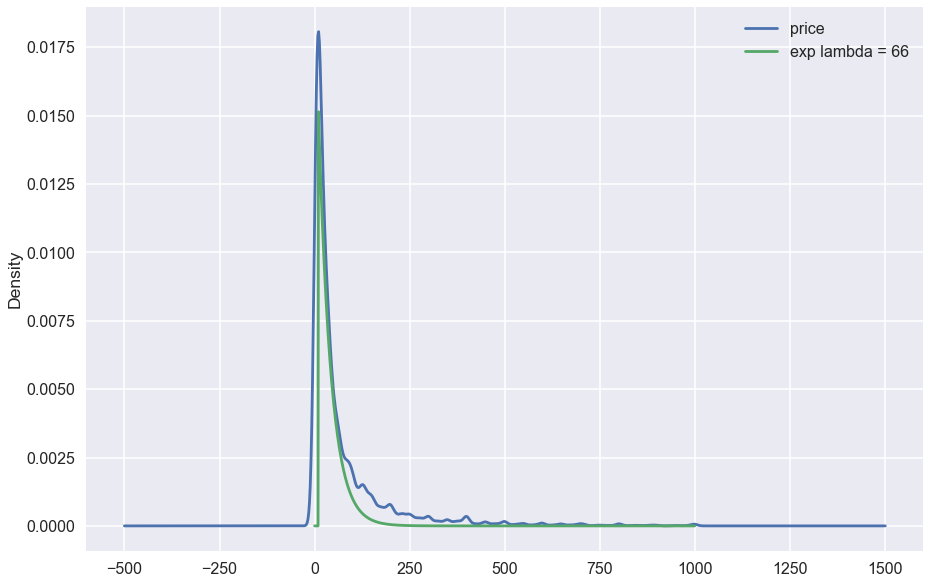

In [455]:
from scipy.stats import expon
import scipy.stats

d = df_plot[['price']]
ax = d.plot.kde()
x = ax.get_children()[0]._x
y = ax.get_children()[0]._y

scale = 66
loc = -480

pdf_fitted = expon.pdf(x - loc, scale=scale)
plt.plot(pdf_fitted,label= ('exp lambda = ' + str(scale)))
plt.legend(loc='best')
plt.show()

We tried to fit a specific distribution; the pareto distribution to the data provided. We see that if we pick b = 1, we get a close approximation to the result up to a multiplicative constant.

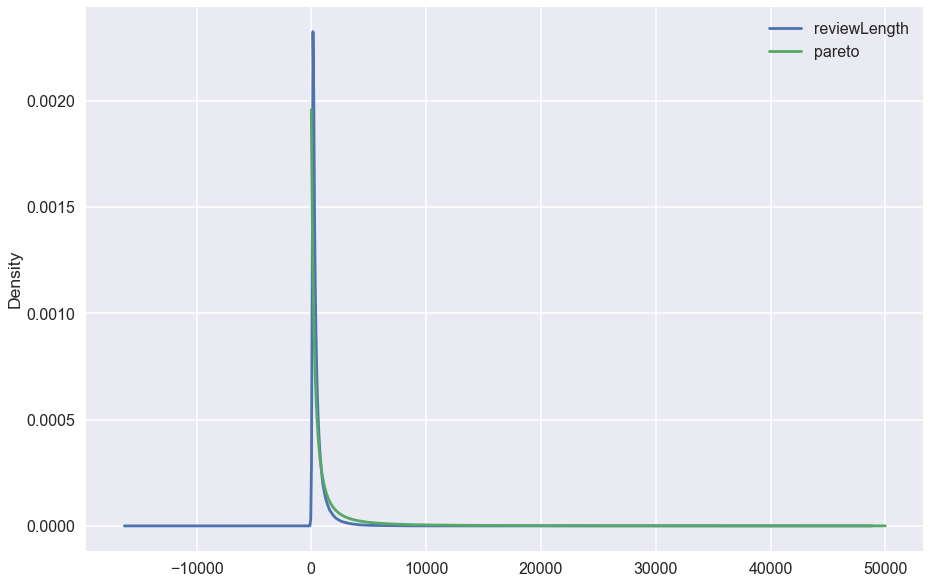

In [456]:
from scipy.stats import pareto
import scipy.stats

d = df_plot[['reviewLength']]
ax = d.plot.kde()

b = 1
x = np.linspace(pareto.ppf(0.01, b),pareto.ppf(0.99, b), 50000)
pdf_fitted = scipy.stats.pareto.pdf(x,b = b)/500
plt.plot(pdf_fitted,label= 'pareto')
plt.legend(loc='best')
plt.show()

### Correlations

We computed the correlation between the price, reviewLength, and the overall. We can see that the overall doesn't seem to be a lot correlated between the price and the review length. But more interestingly there seem to be some correlation between the price and the review lenght. Maybe the user are more passionate about the items they are willing to spend the more money on !

In [12]:
df_merged[['price','reviewLength','overall']].corr()

,price,reviewLength,overall
price,1.000000,0.249120,0.025969
reviewLength,0.249120,1.000000,-0.076393
overall,0.025969,-0.076393,1.000000


# Impressions and characteristics extraction
**<a href="#Table-of-Contents">Back to table of contents</a>**

Now that we have acquired basic insight on our data, we will dive into the core of the project. We will start by extracting basic reviewers impressions on a product. We defines impressions as adjectives that appear frequently in the reviews. Typical examples would be adjectives such as "great", "good" or "excellent". 

Adjectives alone are a good way of quickly extracting an impression on a product. However, they do not offer any context. Indeed, suppose that a laptop turn out to receive multiple times the adjective "good". What exactly is considered by the users as good in this product ? Is it the image quality of the screen, the price or event its performances ? We therefore want to be able to extract product characteristics from reviews. One simple and effective way of doing that is to find collocations of adjective-nouns pairs. Collocations are tuples of words that happen more frequently together than one would expect if they were distributed randomly in the text.

As explained in the introduction, we will extract pairs, also knowns as bigrams, consisting of Adjective-Nouns (like "good quality"), Adverb - Past Participle (like "well made") and verb-adverb (like "works well").

## Identifying parts-of-speech (PoS)

Parts-of-speech are categories of words that exhibit similar grammatical properties such as adjectives, adverbs and verbs. To be able to identify the various categories that we will need for our analysis, we use the [Natual Language Tool Kit (NLTK)](http://www.nltk.org/) package for Python. NLTK provides an interface for the [WordNet](https://wordnet.princeton.edu/) lexical database.

WordNet can be used to find lexical relations between words. It is also capable of returning PoS tags for any given word. The nomenclature chosen for those tags is the taken from the [Penn Treebank Project](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf). The tags used by our pipeline will be the following:

Every tag starting with *JJ*: 
* JJ -	Adjective
* JJR -	Adjective, comparative
* JJS -	Adjective, superlative 

Every tag starting with *RB*:
* RB -	Adverb
* RBR - Adverb, comparative
* RBS - Adverb, superlative 
* VBN -	Verb, past participle 

Every tag starting with *NN*:
* NN -	Noun, singular or mass
* NNS -	Noun, plural
* NNP -	Proper noun, singular
* NNPS - Proper noun, plural 

Every tag starting with *VB*
* VB -	Verb, base form
* VBD -	Verb, past tense
* VBG -	Verb, gerund or present participle
* VBN -	Verb, past participle
* VBP -	Verb, non-3rd person singular present
* VBZ -	Verb, 3rd person singular present 

## Extracting impressions

For a reason that will become clear in a minute, we start by defining a function which is able to verify if a word is contained in a dictionnary:

In [7]:
compound_dictionnary = pd.read_pickle("data/filtered_compound_words.pickle.gz")

def is_compound_word(word):
    i = compound_dictionnary.searchsorted(word)

    if i == len(compound_dictionnary):
        return False

    x = compound_dictionnary.iloc[i].values
    return x[0] == word

Then we implement the adjective extraction. We will feed to this function the result of concatenating all the review for a given product.

In [6]:
def isAdjective(token):
    """
    w: Tagged word

    Returns true if the part-of-speech is an adjective
    """
    _, tag = nltk.pos_tag([token])[0]

    return tag == 'JJ' or tag == 'JJS'


def getAdjectives(text):
    """
    text: The concatenation of all the review for a given product

    Returns the collocations of words larger 
    """

    pattern = re.compile('[\\\*\.]+')
    text = re.sub(pattern, " ", text)

    tokens = nltk.word_tokenize(text)

    adjectives = []

    for i, token in enumerate(tokens):

        # Extract adjectives
        if isAdjective(token):
            one_before = max(i - 1, 0)
            two_before = max(i - 2, 0)
            one_after = min(i + 1, len(tokens)-1)

            if not is_compound_word(tokens[i] + "_" + tokens[one_after]):
                # Identify negations
                if tokens[one_before] == 'not':
                    adjectives.append(tokens[one_before] + " " + tokens[i])
                elif tokens[two_before] == 'not':
                    adjectives.append(tokens[two_before] + " " + tokens[i])
                else:
                    adjectives.append(token)

    return Counter(adjectives).most_common(None)

We can now explain why we needed the filtering function. When the review aggregate is processed by the function, the overall string is decomposed into several words which we call tokens. Those tokens are kept only if their PoS tag is an adjective, JJ, or a superlative, JJS. However, there will be words considered adjective while they actually are part of a compound word. One of the best example of this is the noun "hard drive". It will obviously appear with very high frequency on reviews dedicated to hard drives and our algorithm will pick up "hard", as "hard" is by itself an adjective. This is why we need to filter out cases in which the token is part of a compound word. The way we obtained this dictionnary deserves more explanation.

## Creating a dictionnary for filtering out tokens

Findind a list of modern english words is not an easy task. Almost every dataset that can be found on the internet does not include nouns relevant for our work (such as hard drive or optical mouse). There are some online APIs such as [Oxford Dictionnary API](https://developer.oxforddictionaries.com/) or [Words API](https://www.wordsapi.com/) which return very rich results but they are priced prohibitively high, in the hundreds of dollars for the use we would make of them.

The set of all titles can be downloaded [here](https://dumps.wikimedia.org/enwiktionary/latest/) under the name `enwiktionary-latest-all-titles-in-ns0.gz` where `ns0` denotes the zero namespace. This namespace contains all wikipedia articles (More information about wikipedia namespaces can be found [here](https://en.wikipedia.org/wiki/Wikipedia:Namespace).

Because we only need compound words, we will be able to greatly reduce the size of the wiktionary dataset:

In [206]:
wiki = pd.DataFrame.from_csv('data/enwiktionary-latest-all-titles-in-ns0', sep='\t').reset_index()

print(len(wiki))
# Normalize the representation of title
wiki.page_title = wiki.page_title.str.lower()

# Keep only compound words, spaces are represented using underscores
wiki = wiki[wiki.page_title.str.contains('_', na=False)]

# Remove garbage pages entered by the user by keeping only alphanumeric titles
wiki_filtered = wiki[wiki.page_title.str.contains("^[a-z_]+$", na=False, regex=True)]

# Remove entries which are not simple compound words
wiki_filtered = wiki_filtered[wiki_filtered.page_title.str.replace('[a-z]', '').apply(len) < 2]

compound_words = wiki_filtered.page_title
compound_words = compound_words.sort_values(ascending=True)
compound_words.head()
print(len(compound_words))

compound_words.to_pickle("data/filtered_compound_words.pickle.gz", compression='gzip')

5442799
156722


The few preprocessing steps above allow us to reduce the size of the dictionnary from 5 million down to ~200k entries. 

## Extracting characteristics

To extract collocations of type adjective-noun, adverb-past participle and verb-adverb we start by defining a function that identifies if the bigram correspond to any of these types. 

In [49]:
def filterTags(w1,w2):
    """
    w1: First tagged word
    w2: Second tagged word
    
    Returns true if the bigram collocation is of type adjective-noun, adverb-past participle or verb-adverb
    """
    _, tag1 = nltk.pos_tag(nltk.word_tokenize(w1))[0]
    _, tag2 = nltk.pos_tag(nltk.word_tokenize(w2))[0]
    
    return  (tag1.startswith('JJ') and tag2.startswith('NN')) or \
            (tag1.startswith('RB') and tag2.startswith('VBN')) or \
            (tag1.startswith('VB') and tag2=="JJ")

For the same reason as mentioned in the impression extraction, we define a funtion which will filter out bigrams that actually correspond to compound nouns.

We then implement the core of the collocation extraction. We use the pointwise mutual information metric to identify bigrams of interest and keep only those that occur at least three times. We further filter out bigrams not in any of the three interesting cases mentioned above. 

In [ ]:
def getCollocations(text, window=2,  find_trigrams=False):
    """
    text: The concatenation of all the review for a given product
    
    Returns the collocations of words larger 
    """
    
    brigram_res = []
    
    pattern = re.compile('(\_)+')
    text = re.sub(pattern, " ", text)
    
    tokens = nltk.word_tokenize(text)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bigram_finder = nltk.BigramCollocationFinder.from_words(tokens, window_size=window)
    
    # Ignore bigram that are infrequent
    bigram_finder.apply_freq_filter(3) 
    
    # Retrieves the most common bigrams
    bigram_res = bigram_finder.nbest(bigram_measures.pmi, None) 
    bigram_res = [(x,round(bigram_finder.score_ngram(bigram_measures.raw_freq, x[0], x[1]),2)*200) 
                  for x in bigram_res if filterTags(x[0],x[1]) and not is_compound_word(x[0]+"_"+x[1])]
    
    if(len(bigram_res) > 0):
        return bigram_res
    else:
        return np.nan

## Increasing pipeline performance
The step of finding interesting collocations is by far the most computationnaly expensive and the bottleneck of our pipeline. However, there's a simple way of mitigating this. The key observation is that each product can be analyzed separately since we aggregate all reviews with their respective product. This means that we can parallelize the collocation finding algorithm over several products. Unfortunately, IPython notebooks do not support the use of multi-threaded code. We had to move it to the [ThreadedCollocations.py](ThreadedCollocations.py) file. The code there simply loads our dataset, setup a pool of 8 worker threads and call the function `getCollocations` on each product. Finally, it saves the resulting dataframe in a pickle file. The algorithm can parse all the 63k products (~1.6 million reviews)  in approximately 10 minutes on a laptop processor. We load the results from a pickle file below:

In [207]:
collocations = pd.read_pickle("elec_collocations_adjectives.pickle")
collocations = collocations.dropna(how = 'any')
display(collocations.head(10))

,asin,reviewText,rawAdjectives
1,0594451647,"[((bad, cable), 0.436)]","[(new, 9), (great, 7), (little, 4), (good, 4),..."
2,0594481813,"[((main, reason), 0.016), ((highly, recommende...","[(great, 156), (good, 97), (other, 88), (much,..."
4,1400501466,"[((external, monitor), 0.024), ((newest, versi...","[(great, 96), (good, 51), (easy, 51), (nice, 4..."
5,1400501520,"[((rechargeable, batteries), 0.128)]","[(good, 11), (manual, 8), (new, 6), (little, 6..."
12,1400698987,"[((portable, dvd), 0.8420000000000001)]","[(portable, 14), (little, 9), (great, 9), (goo..."
16,3930992868,"[((most, part), 0.044000000000000004), ((inter...","[(good, 27), (same, 19), (much, 17), (other, 1..."
20,7507825604,"[((numeric, keypad), 0.03), ((highly, recommen...","[(great, 71), (easy, 48), (nice, 46), (good, 4..."
26,9573212900,"[((great, device), 0.1), ((is, great), 0.1)]","[(great, 25), (good, 13), (much, 12), (other, ..."
28,9575871979,"[((various, settings), 0.156), ((extra, batter...","[(great, 23), (good, 16), (extra, 8), (easy, 8..."
30,9862510447,"[((much, fun), 0.13), ((classic, arcade), 0.13...","[(great, 16), (good, 13), (nice, 12), (much, 1..."


In [208]:
df_elec = pd.read_pickle('data/electronics_serialized.pickle')
df_product = df_elec.groupby(["asin"])['reviewText'].agg(lambda x: ''.join(set(x.str.lower()))).reset_index()

df_product = df_product.merge(collocations, left_on='asin', right_on='asin', how='inner')
df_product = df_product.rename(index=str, columns={"reviewText_y": "bigrams","reviewText_x":"reviewText"})
df_product.head()

,asin,reviewText,bigrams,rawAdjectives
0,0594451647,this adapter easily connects my nook hd 7&#34;...,"[((bad, cable), 0.436)]","[(new, 9), (great, 7), (little, 4), (good, 4),..."
1,0594481813,my son crewed my hd charger cord so i needed a...,"[((main, reason), 0.016), ((highly, recommende...","[(great, 156), (good, 97), (other, 88), (much,..."
2,1400501466,i pulled the trigger on three of these on pre-...,"[((external, monitor), 0.024), ((newest, versi...","[(great, 96), (good, 51), (easy, 51), (nice, 4..."
3,1400501520,if you are looking for a very light and compac...,"[((rechargeable, batteries), 0.128)]","[(good, 11), (manual, 8), (new, 6), (little, 6..."
4,1400698987,i received the basic nook as a christmas gift....,"[((portable, dvd), 0.8420000000000001)]","[(portable, 14), (little, 9), (great, 9), (goo..."


In [209]:
df_product_filtered = df_product.copy()
df_product_filtered = df_product_filtered[df_product_filtered.bigrams.notnull()
                                         &
                                          df_product_filtered.rawAdjectives.notnull()]

And finally display our results:

In [210]:
df_product_filtered

,asin,reviewText,bigrams,rawAdjectives
0,0594451647,this adapter easily connects my nook hd 7&#34;...,"[((bad, cable), 0.436)]","[(new, 9), (great, 7), (little, 4), (good, 4),..."
1,0594481813,my son crewed my hd charger cord so i needed a...,"[((main, reason), 0.016), ((highly, recommende...","[(great, 156), (good, 97), (other, 88), (much,..."
2,1400501466,i pulled the trigger on three of these on pre-...,"[((external, monitor), 0.024), ((newest, versi...","[(great, 96), (good, 51), (easy, 51), (nice, 4..."
3,1400501520,if you are looking for a very light and compac...,"[((rechargeable, batteries), 0.128)]","[(good, 11), (manual, 8), (new, 6), (little, 6..."
4,1400698987,i received the basic nook as a christmas gift....,"[((portable, dvd), 0.8420000000000001)]","[(portable, 14), (little, 9), (great, 9), (goo..."
5,3930992868,"brought back my ipod video 30g back life, easy...","[((most, part), 0.044000000000000004), ((inter...","[(good, 27), (same, 19), (much, 17), (other, 1..."
6,7507825604,i bought 4 of these for my test equipment - th...,"[((numeric, keypad), 0.03), ((highly, recommen...","[(great, 71), (easy, 48), (nice, 46), (good, 4..."
7,9573212900,i needed an external cdrw/dvd drive for my tos...,"[((great, device), 0.1), ((is, great), 0.1)]","[(great, 25), (good, 13), (much, 12), (other, ..."
8,9575871979,"very powerful batteries, use it a lot and does...","[((various, settings), 0.156), ((extra, batter...","[(great, 23), (good, 16), (extra, 8), (easy, 8..."
9,9862510447,"this microphone does what it states, but nothi...","[((much, fun), 0.13), ((classic, arcade), 0.13...","[(great, 16), (good, 13), (nice, 12), (much, 1..."


# Sentiment Analysis
**<a href="#Table-of-Contents">Back to table of contents</a>**

We now want to be able to categorise the opinions we extracted in the previous part of this notebook. One way of doing this is to use [SentiWordNet](http://nmis.isti.cnr.it/sebastiani/Publications/LREC06.pdf). SentiWordNet is a lexical resource for performing sentiment analysis on texts. It is base on WordNet. Fortunately, the NLTK package for python provides an interface for using SentiWordNet.

We implemented a class on top of NLTK's support for SentiWordNet in order to provide a convenient interface to tokenize and classify opinions. The implementation is encapsulated in the SentimentAnalyzer class in the [SentimentAnalyser.py](SentimentAnalyser.py) file.

### Classifying opinions

SentiWordNet provides a positivity score for each word which can then be used to asses the positivity of a sentence of for our pipeline, a pair of words. A score above than 0 denotes a positive connotation of the word while a score below 0 denotes a negative connotation. See the following examples: 

In [15]:
from SentimentAnalyser import *

In [16]:
sentimentAnalyzer = SentimentAnalyser()

examples = ['Hello world', 'The screen is poorly assembled', 'Worst purchase I\'ve done', 'Excellent quality', 'Best deal']

for sentence in examples:
    print("{} : {}".format(sentence, sentimentAnalyzer.sentiment_score_for_raw_sentence(sentence)))

Hello world : 0.0
The screen is poorly assembled : -0.75
Worst purchase I've done : -1.0
Excellent quality : 1.375
Best deal : 0.75


Using those score, we would then classify the second and the third as being negative ans the fourth and fifth as being positive. While looking very promising this approach has a major flaw for our application:

In [17]:
examples = ['Cheap quality', 'Low price']

for sentence in examples:
    print("{} : {}".format(sentence, sentimentAnalyzer.sentiment_score_for_raw_sentence(sentence)))

Cheap quality : 0.375
Low price : -0.25


It is not able to classify correctly opinions which are positive but writte with negatively connoted words and vice versa. This is why we propose an alternative approach.

# Sentiment Analysis, revisited
**<a href="#Table-of-Contents">Back to table of contents</a>**

As the method above doesn't work perfectly, we implemented another method more simple.

First, we set the negative sentiment to -1 and the positive to 1. We divided the initial dataset into entries with an overall score smaller to three (bad sentiment -1) and entries with an overall score higher than 3 (good sentiment 1). We then equilibrate the data to have the same number of positive and negative reviews.

In [18]:
from nltk import bigrams
from collections import Counter
from random import randint

df_ML = df_elec.copy()
# Map every overall to a score {-1,1}
df_ML['score'] = df_elec["overall"].apply(lambda x : -1 if x < 3 else 1)

df_0 = (df_ML[df_ML["score"] == -1])
df_1 = (df_ML[df_ML["score"] == 1])

print(df_0.shape)
print(df_1.shape)

if df_0.shape[0] > df_1.shape[0]:
    df_0 = df_0.sample(df_1.shape[0],random_state = 42)
else:
    df_1 = df_1.sample(df_0.shape[0],random_state = 42)

counts_0 = Counter()
for sent in df_0["reviewText"]:
    words = nltk.word_tokenize(sent)
    counts_0.update(nltk.bigrams(words))

counts_1 = Counter()
for sent in df_1["reviewText"]:
    words = nltk.word_tokenize(sent)
    counts_1.update(nltk.bigrams(words))
    
counts_1.subtract(counts_0)

(190864, 10)
(1498324, 10)


Then, we count the number of bigram that have a positive score (smaller than 3) and we substract from them the number of bigram that have a negative score after matching the same bigrams together. Hence if the overall count is negative, this bigram is in more negative than positive reviews, hence we can deduce that the bigram is negative, we will assign -1. On the other hand, if it's positive, we can deduce that the bigram is positive, we will assign 1.

In the case of a count equal to 0 (same number of positive and negative bigrams), we will assign a random score {-1,1}.

In [19]:
random.seed(a=42)

def getPredictionString(x):
    w1,w2 = x.split(" ")
    w1 = str.lower(w1)
    w2 = str.lower(w2)

    a = counts_1[w1,w2]
    if a == 0:
        return randint(0, 1)*2-1
    else:
        return 1 if a > 0 else -1

def getPredictionArray(x):
    res = []
    
    for i in x:
        res.append(getPredictionString(i))
        
    return res

def getScore(x,y):
    score = 0
    x = getPredictionArray(x)
    
    for x_i,y_i in zip(x,y):
        score += np.abs(x_i - y_i)/(2*len(x)) 
    return 1 - score   

We see that for some common entries, we get the result that we expect:

In [20]:
X = ["Low price","high quality","low quality","well made",'poorly made','good product','additional memory','low light','original battery','dead pixels','special edition']
y = [1,1,-1,1,-1,1,1,1,1,-1,1]
  
print(getScore(X,y))

1.0


# Application to brand names

**<a href="#Table-of-Contents">Back to table of contents</a>**

Finally, we can now assign a score to each product with respect to their reviews. We will use a simple rule: we will first scale the frequency of each bigram by it's sentiment score (1 or -1); then we will simply average the scaled scores of the reviews to get the product score. We can get the score associated to the brand by avering each score of it's product.

One additional step that can be taken is to regroup and aggregate the characteristics of the products by brands. This way we can see if certain brands are systematically associated with certain opinion on their products.

To perform this, we will define a very simple scoring mechanism. We count the number of times each bigram appears for a certain brand and if this number reaches a certain threshold we attribute it to the brand.

In [21]:
def isInDescriptionOrTitle(text,description,title):
    """
    Filters the characteristics that are present in the name or the description of the product. 
    This will ensure that the words exctracted are only sentiment-related characteristics and not 
    some attribute of the object. This can be applied for the word 'hard drive'.
    """
    res = [] 
    for t in text:
        ((a,b),num) = t
        if (a + ' ' + b).lower() not in str(description).lower() and (a + ' ' + b).lower() not in str(title).lower():
            res.append(t)
    if len(res) > 0:
        return res
    else:
        return np.nan
    
def getProductScore(text):
    """
    Takes the different characteristics of a product. 
    Return the score by taking the averaged sum of the sentiment scores of each characteristic.
    """
    if len(text) == 0:
        return np.nan
    
    res = 0.0  
    for t in text:
        ((a,b),num) = t
        res += getPredictionString(a + ' ' + b) * float(num)
    return res

def getCharacteristicsAsString(text):
    """
    Return the characteristics as a string separated by ' / ' for each characteristic.
    """
    res = []
    for t in text:
        ((a,b),num) = t
        res.append((a + ' ' + b).lower())
    return " / ".join(res)


def getUniqueCharacteristicsFromString(text):
    """
    Return the unique characteristics from the original string text as a string separated by ' / ' 
    for each characteristic.
    """
    temp = text.split(' / ')
    res = set(temp)
    return " / ".join(res)

In [22]:
df_final = df_product_filtered.merge(df_meta, left_on='asin', right_on='asin', how='inner')
df_final = df_final[(df_final['brand'] != 'Unknown') & (df_final['brand'] != '')]

# Filter collocations which are in title or product description
df_final['bigrams'] = df_final.apply(lambda x : isInDescriptionOrTitle(x['bigrams'],x['description'],x['title']), axis=1)
df_final = df_final[pd.notnull(df_final['bigrams'])]
df_final['brand'] = df_final['brand'].str.title()

display(df_final.head(3))

,asin,reviewText,bigrams,title,description,imUrl,categories,price,salesRank,related,brand
0,0528881469,"well, what can i say. i've had this unit in m...","[((basic, garmin), 0.262)]",Rand McNally 528881469 7-inch Intelliroute TND...,"Like its award-winning predecessor, the Intell...",http://ecx.images-amazon.com/images/I/51FnRkJq...,"[[Electronics, GPS & Navigation, Vehicle GPS, ...",299.99,NaN,"{'buy_after_viewing': ['B006ZOI9OY', 'B00C7FKT...",NaN
1,0972683275,we needed something to extend our tv away from...,"[((retail, stores), 0.034), ((heavy, duty), 0....",VideoSecu 24&quot; Long Arm TV Wall Mount Low ...,The VideoSecu TV mount is a mounting solution ...,http://ecx.images-amazon.com/images/I/41hYJ9Mw...,"[[Electronics, Accessories & Supplies, Audio &...",29.99,{},"{'also_bought': ['B000X3KOD2', 'B0074FGR74', '...",Videosecu
2,1400501466,i was looking at expensive tablets that were m...,"[((ad-supported, versions), 0.046), ((angry, b...","Barnes &amp; Noble NOOK Tablet 16gb (Color, BN...","Enjoy your digital books, magazines and newspa...",http://ecx.images-amazon.com/images/I/41StLxJb...,"[[Electronics, Computers & Accessories, Tablets]]",188.88,NaN,"{'also_bought': ['B007H564NS', 'B005HM8BRU', '...",NaN


In [23]:
# Extract the characteristics name
df_final["word"] = df_final.apply(lambda x : getCharacteristicsAsString(x['bigrams']), axis=1)

# Compute the score
df_final['score'] = 0
df_final['score'] =  df_final.apply(lambda x : getProductScore(x["bigrams"]), axis=1)

In [24]:
display(df_final.head(3))

,asin,reviewText,bigrams,title,description,imUrl,categories,price,salesRank,related,brand,word,score
0,0528881469,"well, what can i say. i've had this unit in m...","[((basic, garmin), 0.262)]",Rand McNally 528881469 7-inch Intelliroute TND...,"Like its award-winning predecessor, the Intell...",http://ecx.images-amazon.com/images/I/51FnRkJq...,"[[Electronics, GPS & Navigation, Vehicle GPS, ...",299.99,NaN,"{'buy_after_viewing': ['B006ZOI9OY', 'B00C7FKT...",NaN,basic garmin,-0.262
1,0972683275,we needed something to extend our tv away from...,"[((retail, stores), 0.034), ((heavy, duty), 0....",VideoSecu 24&quot; Long Arm TV Wall Mount Low ...,The VideoSecu TV mount is a mounting solution ...,http://ecx.images-amazon.com/images/I/41hYJ9Mw...,"[[Electronics, Accessories & Supplies, Audio &...",29.99,{},"{'also_bought': ['B000X3KOD2', 'B0074FGR74', '...",Videosecu,retail stores / heavy duty / fully extended,0.148
2,1400501466,i was looking at expensive tablets that were m...,"[((ad-supported, versions), 0.046), ((angry, b...","Barnes &amp; Noble NOOK Tablet 16gb (Color, BN...","Enjoy your digital books, magazines and newspa...",http://ecx.images-amazon.com/images/I/41StLxJb...,"[[Electronics, Computers & Accessories, Tablets]]",188.88,NaN,"{'also_bought': ['B007H564NS', 'B005HM8BRU', '...",NaN,ad-supported versions / angry birds,-0.184


## Brand rankings 

In [29]:
big_brands = ["Apple","Microsoft","Sony","Samsung","Amd","Belkin","Asus","Canon","Dell","Logitech","Lg","Panasonic",\
              "Targus","Nikon","Acer","Lenovo","Toshiba","Philips","Seagate"]

Finally to get the scores of the different brand we will sum each scores and take the mean to have respectively the score and the mean score.

In [25]:
# Group by brand
f = {'score':['sum','mean','count'],'word': lambda x: ' / '.join(set(x))}
df_brand_rank = df_final[['brand','word','score']].groupby(['brand']).agg(f)
df_brand_rank.columns = df_brand_rank.columns.droplevel()
df_brand_rank = df_brand_rank.reset_index()

#Rename columns
df_brand_rank = df_brand_rank.rename(columns={'sum': 'score','mean': 'mean_score', '<lambda>': 'words','count':'number_of_product'})

# Only keep brands with al least 10 products
df_brand_rank = df_brand_rank[df_brand_rank['number_of_product']>10]
# Make sure to have unique characteristics and existing brand
df_brand_rank['words'] = df_brand_rank.apply(lambda x : getUniqueCharacteristicsFromString(x['words']), axis=1)

In [26]:
display(df_brand_rank.sort_values('mean_score',ascending=False))

,brand,score,mean_score,number_of_product,words
177,Bower,6.474,0.539500,12,good quality / manual mode / extra battery / m...
473,Fotasy,6.616,0.472571,14,rapid stuff / same depth / manual mode / origi...
920,Pelican,6.906,0.460400,15,pelican case / pelican cases / other equipment...
1082,Sib,7.098,0.443625,16,original cord / extra battery / original hp / ...
79,Arctic,4.428,0.402545,11,external power / black wire / artic silver / s...
1214,Tiffen,6.384,0.399000,16,vertical position / true macro / neutral densi...
14,Accessory Genie,4.338,0.361500,12,good quality / extra battery / ergonomic metal...
809,Monoprice,14.364,0.350341,41,many times / many people / flat screen / real ...
474,Fotodiox,11.146,0.348313,32,manual mode / heavy duty / soft metal / old mi...
1177,Tamrac,10.100,0.348276,29,little things / heavy duty / ultra-light insta...


We can plot the different mean scores of the brands: 

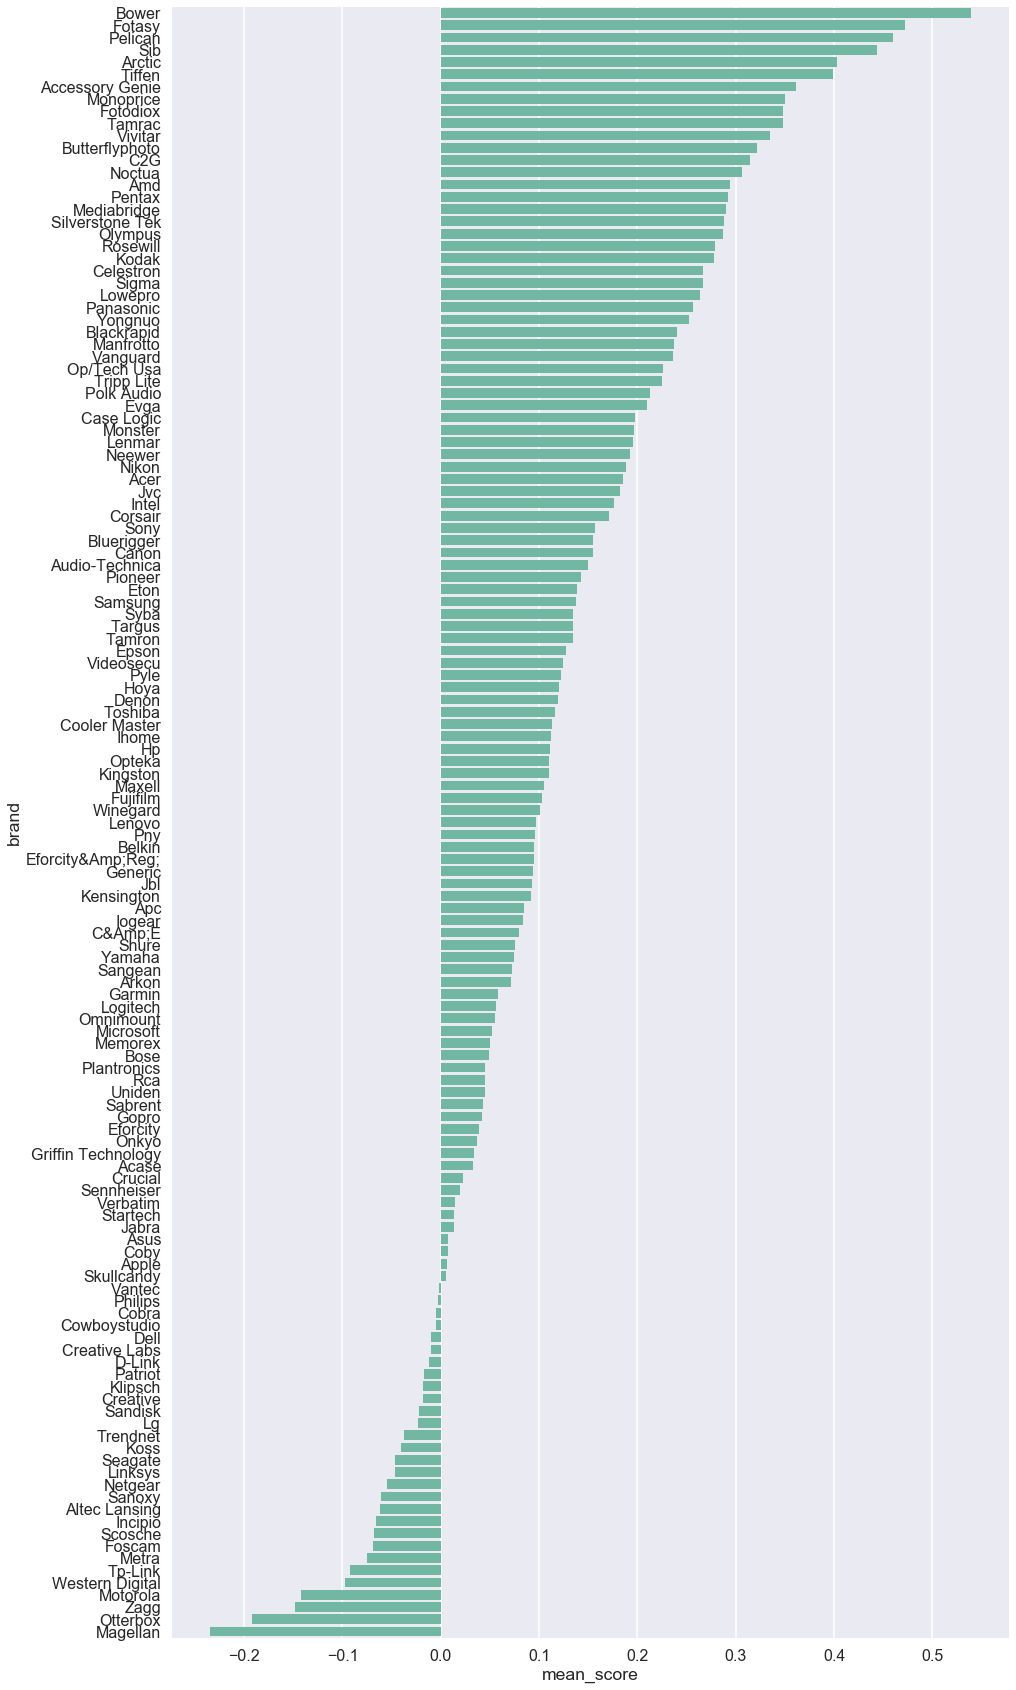

In [28]:
fig, ax = pyplot.subplots(figsize=(15,30))
sns.barplot(y="brand",x='mean_score', ax = ax,orient='h',data=df_brand_rank.sort_values('mean_score',ascending=False),palette = sns.color_palette("BuGn_r", 1));
plt.show()

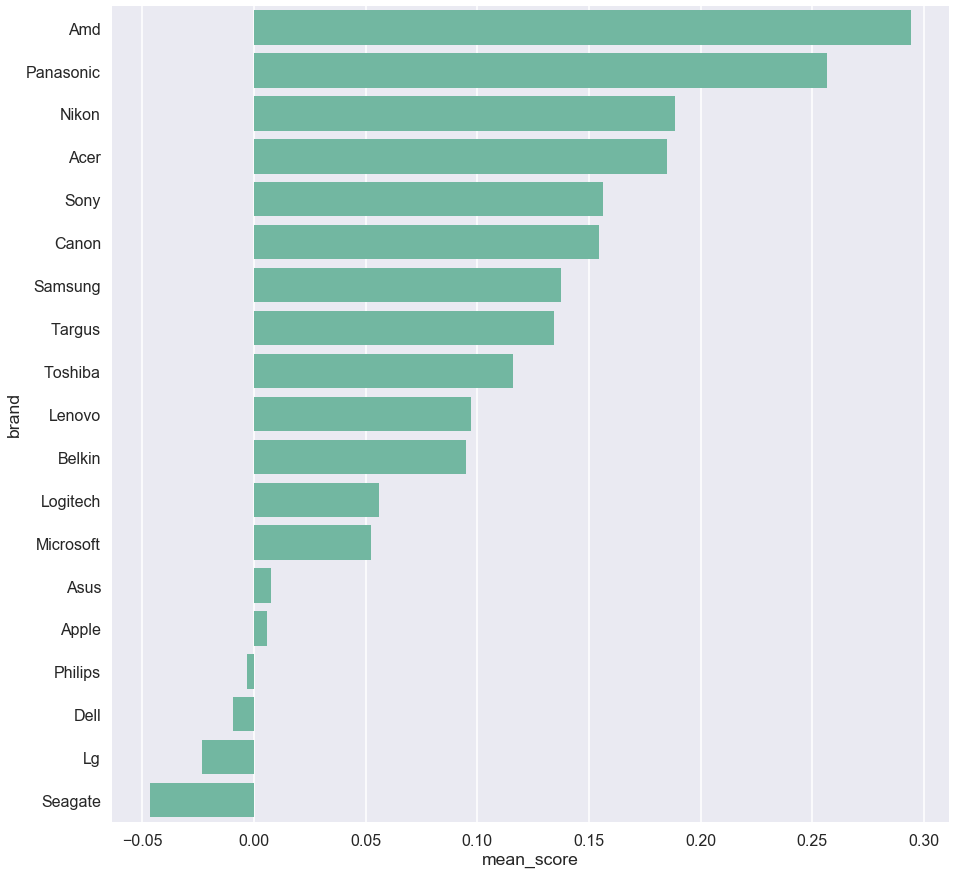

In [30]:
fig, ax = pyplot.subplots(figsize=(15,15))

df_big_brand_rank = df_brand_rank[df_brand_rank['brand'].isin(big_brands)]
sns.barplot(y="brand",x='mean_score', ax = ax,orient='h',data=df_big_brand_rank.sort_values('mean_score',ascending=False),palette = sns.color_palette("BuGn_r", 1));
plt.show()

## Brand characteristics

In [31]:
def getCharacteristics(bigrams,threshold = 3):
    """Return the characteristics from the list of bigrams that appear more than threshold.
    """
    res = []
    for t in bigrams:
        ((a,b),num) = t
        res.append((a + ' ' + b).lower())
        
    res = list(set([(i,res.count(i)) for i in res if res.count(i) >= threshold]))
    res.sort(key=lambda tup: tup[1],reverse=True)
    
    return " / ".join("(%s,%s)" % tup for tup in res) if len(res) > 0 else np.nan

In [32]:
# Group by brand
f = {'bigrams':'sum'}
df_brand_characteristics = df_final[['brand','bigrams']].groupby(['brand']).agg(f)
df_brand_characteristics = df_brand_characteristics.reset_index()

# Make sure to have unique characteristics and existing brand
df_brand_characteristics['characteristics'] = df_brand_characteristics.apply(lambda x : getCharacteristics(x['bigrams']), axis=1)
df_brand_characteristics = df_brand_characteristics[pd.notnull(df_brand_characteristics['characteristics'])]
df_big_brand_characteristics = df_brand_characteristics[df_brand_characteristics['brand'].isin(big_brands)]

In [33]:
display(df_big_brand_characteristics)

,brand,bigrams,characteristics
54,Amd,"[((dual, core), 2.112), ((dual, core), 0.37), ...","(dual core,3)"
75,Apple,"[((few, weeks), 0.026), ((large, hands), 0.072...","(angry birds,7)"
95,Asus,"[((high, quality), 0.14400000000000002), ((dro...","(dead pixels,8) / (high quality,5) / (fully ch..."
138,Belkin,"[((get, free), 0.13), ((different, colors), 0....","(high quality,10) / (well made,8) / (same time..."
225,Canon,"[((ultra, sonic), 0.024), ((75-300mm, f4-5.6),...","(wide angle,27) / (low light,22) / (white bala..."
322,Dell,"[((few, months), 0.242), ((real, dell), 0.634)...","(dead pixels,3)"
727,Logitech,"[((apply, hard), 0.038), ((interchangeable, fa...","(low light,5) / (scientific atlanta,5) / (high..."
854,Nikon,"[((good, condition), 0.262), ((old, nikon), 0....","(low light,25) / (wide angle,22) / (full frame..."
905,Panasonic,"[((many, hours), 0.082), ((smaller, heads), 0....","(low light,15) / (wide angle,7) / (full frame,..."
925,Philips,"[((other, brands), 0.268), ((bad, disc), 0.339...","(flat screen,3)"


# Conclusion